In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv("Data/Concatenated Features/by_year_features.csv")
df= df.fillna(0)
df.head()

,indeks,(SubTotal),Przepisy długoterminowe,Amortyzacja i straż pożarna,Kapitał partnerstwa głównego,Akcje mniejszościowe,Przepisy zadłużenia,Żywe istoty,Zachęta państwowa i pomoc,Zwiększenie wartości fundusze,...,Zobowiązania długoterminowe,Inne dochody i wydatki przed opodatkowaniem,Yab. Money Trans. Różnica. Efekt. Poprzedni.nak.ve nak. Tak jak. Wzrost/spadek netto,Sprzedaż zagraniczna,Sprzedaż krajowa,Akcje zysków/strat inwestycji cenianych metodą samowystarczalności,Samo -właściwość,Źródło_pliku,Nazwa,Rok
0,Yıllık,4.524640e+08,678404.0,1242248.0,1.387926e+08,0.0,2852756.0,0.0,0.0,0.0,...,2806817.0,449296.0,-9990337.0,0.0,0.0,0.0,1.387926e+08,A1CAP_2020.xlsx,A1CAP,2020
1,Yıllık,8.515088e+08,0.0,3263754.0,2.966258e+08,0.0,6670834.0,0.0,0.0,0.0,...,8695590.0,777230.0,121976765.0,0.0,0.0,0.0,2.966258e+08,A1CAP_2021.xlsx,A1CAP,2021
2,Yıllık,4.019261e+09,4748296.0,12651941.0,1.487849e+09,0.0,70752251.0,0.0,0.0,0.0,...,132279622.0,17107575.0,463136619.0,0.0,0.0,0.0,1.487849e+09,A1CAP_2022.xlsx,A1CAP,2022
3,Yıllık,6.297396e+09,7715324.0,21452328.0,3.696944e+09,0.0,42331251.0,0.0,0.0,0.0,...,34025698.0,6055765.0,691863980.0,0.0,0.0,0.0,3.696944e+09,A1CAP_2023.xlsx,A1CAP,2023
4,Yıllık,8.297508e+09,9773361.0,31826374.0,4.065838e+09,0.0,28062814.0,0.0,0.0,0.0,...,160295553.0,5169826.0,369461172.0,0.0,0.0,0.0,4.065838e+09,A1CAP_2024.xlsx,A1CAP,2024


In [3]:
# 2. Usuń 'indeks', jeśli istnieje
df = df.drop(columns=['indeks', 'Źródło_pliku'], errors='ignore')

# 3. Identyfikator i rok
id_col = 'Nazwa'
rok_col = 'Rok'

# 4. Przekształcenie: iterujemy po wszystkich kolumnach oprócz 'Nazwa' i 'Rok'
value_cols = [col for col in df.columns if col not in [id_col, rok_col]]

# 5. Tworzymy nowy DataFrame z odpowiednio nazwanymi kolumnami
dfs = []
for col in value_cols:
    temp = df[[id_col, rok_col, col]].copy()
    temp.columns = [id_col, rok_col, 'wartość']
    temp['kolumna'] = f"{col}"
    temp['nazwa_cechy_rok'] = temp['kolumna'] + '_' + temp[rok_col].astype(str)
    dfs.append(temp[[id_col, 'nazwa_cechy_rok', 'wartość']])

# 6. Scal wszystkie fragmenty
df_long = pd.concat(dfs, axis=0)

# 7. Pivot do formatu szerokiego
df_wide = df_long.pivot_table(
    index=id_col,
    columns='nazwa_cechy_rok',
    values='wartość',
    aggfunc='first'
).reset_index()

# 8. Spłaszcz kolumny
df_wide.columns.name = None

# 9. Podgląd
df_wide.head()

,Nazwa,(Głównie poza działalnością) Koszty finansowe (-)_2008,(Głównie poza działalnością) Koszty finansowe (-)_2009,(Głównie poza działalnością) Koszty finansowe (-)_2010,(Głównie poza działalnością) Koszty finansowe (-)_2011,(Głównie poza działalnością) Koszty finansowe (-)_2012,(Głównie poza działalnością) Koszty finansowe (-)_2013,(Głównie poza działalnością) Koszty finansowe (-)_2014,(Głównie poza działalnością) Koszty finansowe (-)_2015,(Głównie poza działalnością) Koszty finansowe (-)_2016,...,Żywe istoty_2015,Żywe istoty_2016,Żywe istoty_2017,Żywe istoty_2018,Żywe istoty_2019,Żywe istoty_2020,Żywe istoty_2021,Żywe istoty_2022,Żywe istoty_2023,Żywe istoty_2024
0,A1CAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,ACSEL,NaN,NaN,-146658.0,0.0,-186001.0,-261542.0,-261542.0,-299978.0,-30594.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADEL,-4467984.0,-4467984.0,-2562968.0,-2482437.0,-4188750.0,-5540038.0,-5540038.0,-28096595.0,-25598000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ADESE,NaN,NaN,-10952999.0,-12097631.0,-22325339.0,-8613300.0,-8613300.0,-20467422.0,-34318313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ADGYO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [4]:
# Póki co nie wykorzystane, tylko ocena poziomu braku danych

q = 0.5

# Oblicz odsetek NaN w każdej kolumnie
nan_ratio =df_wide.isna().mean()


# Wybierz kolumny do odrzucenia (mające więcej niż q NaN)
columns_to_drop = nan_ratio[nan_ratio > q].index


print("\n❌ Kolumny, które zostaną odrzucone (> {:.0%} NaN):".format(q))
print(list(columns_to_drop))
len(columns_to_drop)


❌ Kolumny, które zostaną odrzucone (> 50% NaN):
['(Głównie poza działalnością) Koszty finansowe (-)_2008', '(Głównie poza działalnością) Koszty finansowe (-)_2009', '(Głównie poza działalnością) dochód finansowy_2008', '(Głównie poza działalnością) dochód finansowy_2009', '(SubTotal)_2008', '(SubTotal)_2009', 'Akcje mniejszościowe.1_2008', 'Akcje mniejszościowe.1_2009', 'Akcje mniejszościowe_2008', 'Akcje mniejszościowe_2009', 'Akcje zysków/strat inwestycji cenianych metodą samowystarczalności_2008', 'Akcje zysków/strat inwestycji cenianych metodą samowystarczalności_2009', 'Aktywa ogółem_2008', 'Aktywa ogółem_2009', 'Aktywa stojące_2008', 'Aktywa stojące_2009', 'Aktywa wynikające z umów o klienta_2008', 'Aktywa wynikające z umów o klienta_2009', 'Amortyzacja i straż pożarna_2008', 'Amortyzacja i straż pożarna_2009', 'Bezpłatny prąd gotówki_2008', 'Bezpłatny prąd gotówki_2009', 'Całkowite zasoby_2008', 'Całkowite zasoby_2009', 'Dochody podatkowe (wydatki)_2008', 'Dochody podatkowe (wy

266

In [5]:
def nan_procent_przedzial_dla_roku(df: pd.DataFrame, rok: int):
    rok_str = f"_{rok}"
    kolumny = [col for col in df.columns if rok_str in col]
    
    if not kolumny:
        print(f"Rok {rok}: brak kolumn.")
        return
    
    # Oblicz procent NaN w kolumnach danego roku
    nan_pct = df[kolumny].isna().mean() * 100
    
    min_nan = nan_pct.min()
    max_nan = nan_pct.max()
    
    if min_nan == max_nan:
        print(f"Rok {rok}: jednolity udział NaN = {min_nan:.2f}%")
    else:
        print(f"Rok {rok}: udział NaN w kolumnach od {min_nan:.2f}% do {max_nan:.2f}%")

# Wczytaj dane
df = pd.read_csv("Data/Concatenated Features/by_year_features.csv")

# Uruchom dla lat 2007-2024
for rok in range(2007, 2026):
    nan_procent_przedzial_dla_roku(df_wide, rok)

Rok 2007: brak kolumn.
Rok 2008: jednolity udział NaN = 59.10%
Rok 2009: jednolity udział NaN = 59.10%
Rok 2010: jednolity udział NaN = 47.21%
Rok 2011: jednolity udział NaN = 44.14%
Rok 2012: jednolity udział NaN = 41.44%
Rok 2013: jednolity udział NaN = 38.74%
Rok 2014: jednolity udział NaN = 38.74%
Rok 2015: jednolity udział NaN = 36.76%
Rok 2016: jednolity udział NaN = 35.14%
Rok 2017: jednolity udział NaN = 32.97%
Rok 2018: jednolity udział NaN = 22.52%
Rok 2019: jednolity udział NaN = 15.50%
Rok 2020: jednolity udział NaN = 8.11%
Rok 2021: jednolity udział NaN = 0.36%
Rok 2022: jednolity udział NaN = 0.00%
Rok 2023: jednolity udział NaN = 0.00%
Rok 2024: jednolity udział NaN = 0.36%
Rok 2025: brak kolumn.


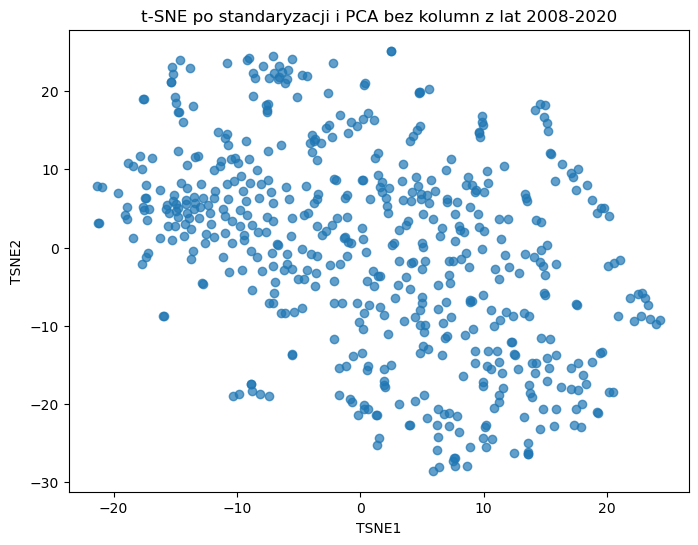

In [6]:
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Przedział lat do usunięcia
rok_min = 2008
rok_max = 2020

def zawiera_rok_z_przedzialu(col_name, rok_min, rok_max):
    match = re.search(r'_(\d{4})', col_name)
    if match:
        rok = int(match.group(1))
        return rok_min <= rok <= rok_max
    return False

# 1. Oddziel kolumnę identyfikatora
identyfikatory = df_wide['Nazwa']

# 2. Weź tylko cechy (bez 'Nazwa')
df_features = df_wide.drop(columns=['Nazwa'])

# 3. Usuń kolumny z lat z przedziału
cols_to_drop = [col for col in df_features.columns if zawiera_rok_z_przedzialu(col, rok_min, rok_max)]
df_features_filtered = df_features.drop(columns=cols_to_drop)

# 4. Uzupełnij NaN zerami
df_features_filtered = df_features_filtered.fillna(0)

# 5. Standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features_filtered)

# 6. PCA 
n_components_pca = min(40, X_scaled.shape[1])
pca = PCA(n_components=n_components_pca, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 7. t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

# 8. DataFrame z wynikami
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Nazwa'] = identyfikatory.values

# 9. Wykres
plt.figure(figsize=(8,6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], alpha=0.7)
plt.title(f't-SNE po standaryzacji i PCA bez kolumn z lat {rok_min}-{rok_max}')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Ocena metod klasteryzacji:
                                          Method Silhouette Davies-Bouldin  \
Agglomerative (average)    Agglomerative-average   0.850601       0.061419   
Agglomerative (single)      Agglomerative-single   0.850601       0.061419   
Agglomerative (complete)  Agglomerative-complete   0.834011       0.435467   
Agglomerative (ward)          Agglomerative-ward    0.82599       0.717319   
KMeans                                    KMeans   0.810452       0.741375   
GMM                                          GMM   0.760905       1.426362   
DBSCAN                                    DBSCAN   0.211975       2.752524   
KMedoids (cosine)                KMedoids-cosine  -0.026544       4.247795   
KMedoids (manhattan)          KMedoids-manhattan  -0.171779        5.46539   
KMedoids (euclidean)          KMedoids-euclidean  -0.214623       4.270767   

                         Calinski-Harabasz  
Agglomerative (average)         171.942055  
Agglomerative (single) 

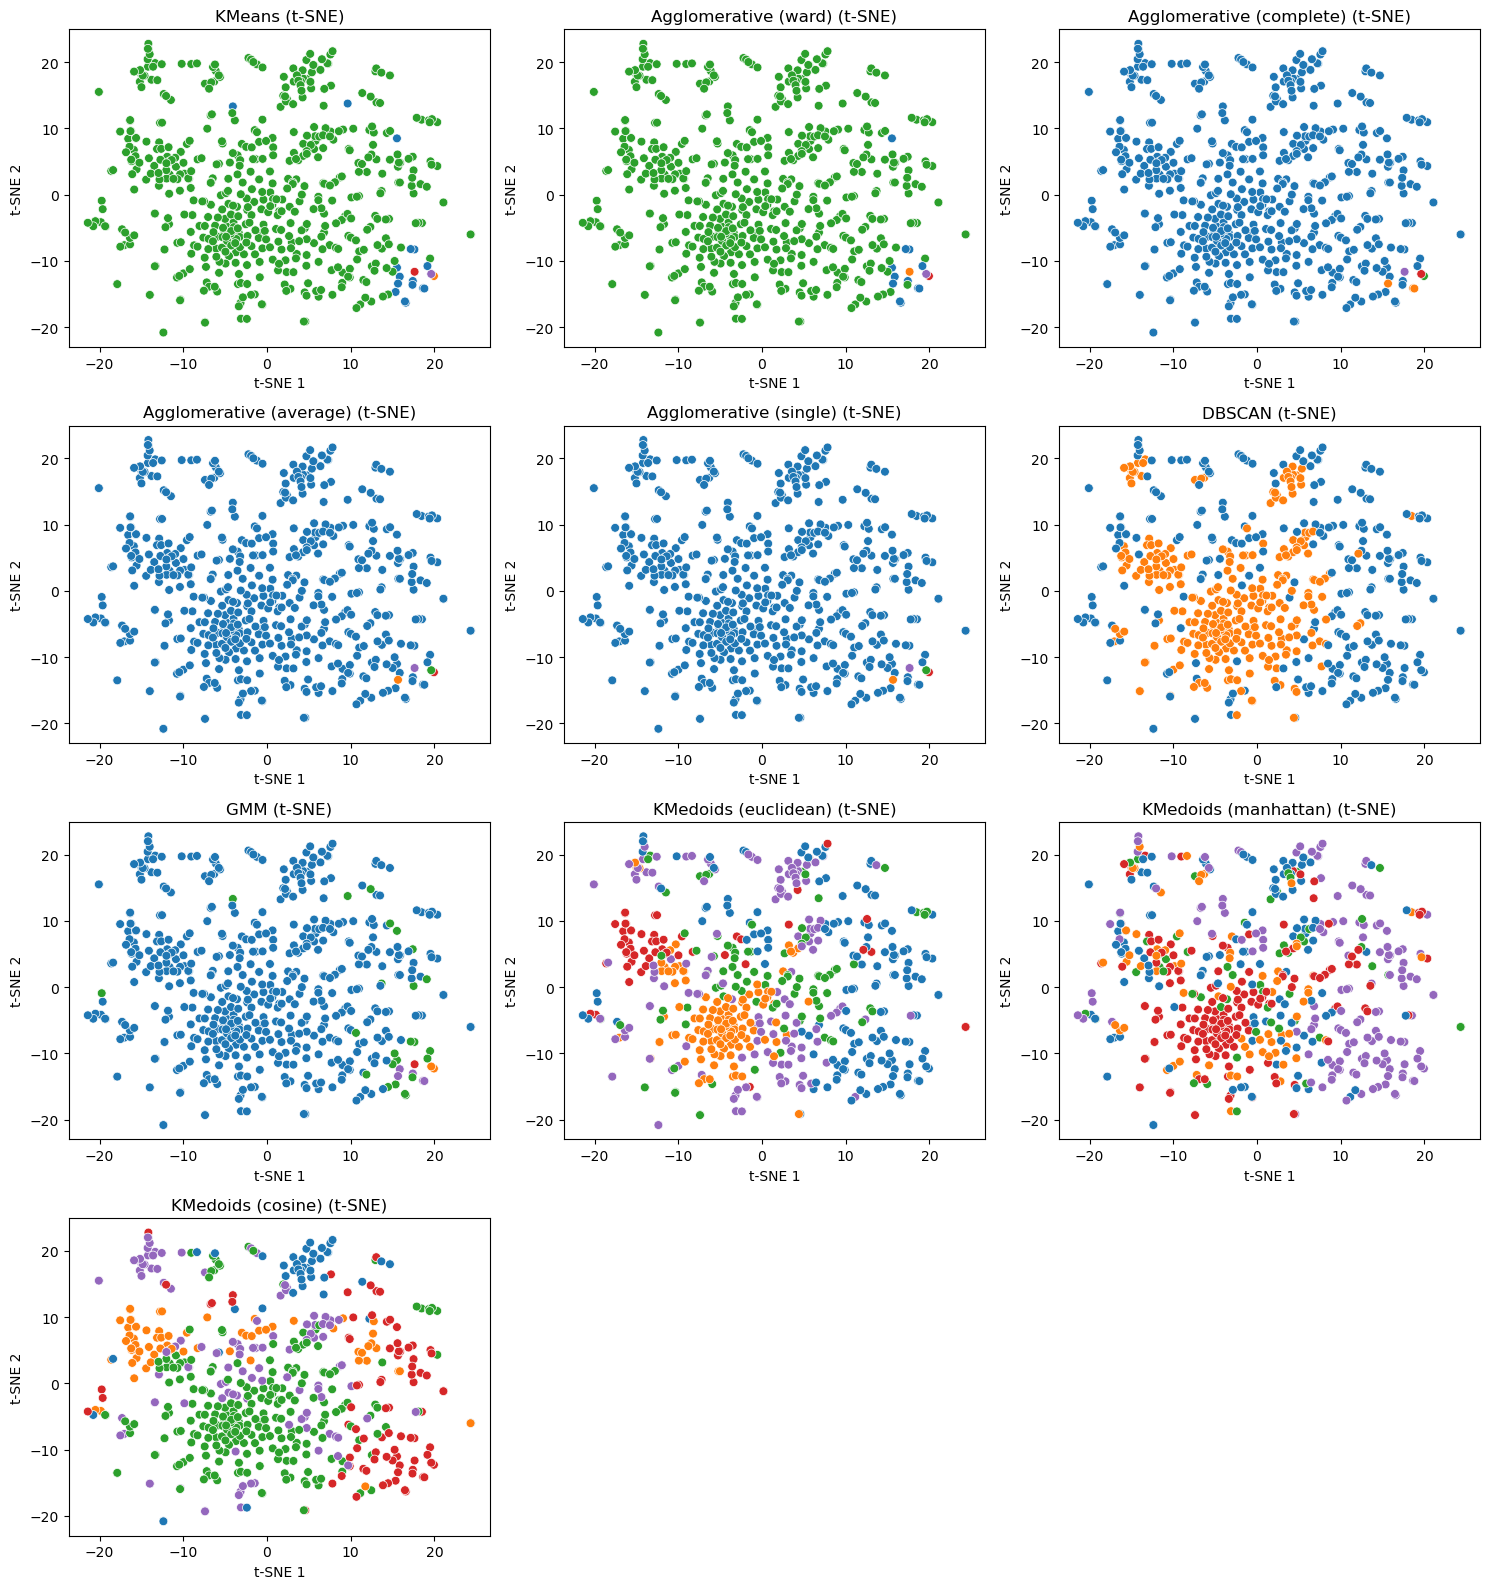

In [9]:
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn_extra.cluster import KMedoids




# Parametry usuwania lat
rok_min = 2008
rok_max = 2020

def zawiera_rok_z_przedzialu(col_name, rok_min, rok_max):
    match = re.search(r'_(\d{4})', col_name)
    if match:
        rok = int(match.group(1))
        return rok_min <= rok <= rok_max
    return False

# Oddziel kolumnę identyfikatora
identyfikatory = df_wide['Nazwa']

# Usuń kolumnę 'Nazwa' i usuń kolumny z latami w przedziale
df_features = df_wide.drop(columns=['Nazwa'])
cols_to_drop = [col for col in df_features.columns if zawiera_rok_z_przedzialu(col, rok_min, rok_max)]
df_features_filtered = df_features.drop(columns=cols_to_drop)

# Uzupełnij NaN zerami (jeśli jeszcze są)
df_features_filtered = df_features_filtered.fillna(0)

# --- Standaryzacja ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features_filtered)

# --- t-SNE ---
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# --- Klasteryzacje ---
n_clusters = 5
results = {}
labels_dict = {}

def evaluate_clustering(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return {"Method": name, "Silhouette": sil, "Davies-Bouldin": db, "Calinski-Harabasz": ch}

# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
results["KMeans"] = evaluate_clustering(X_scaled, kmeans_labels, "KMeans")
labels_dict["KMeans"] = kmeans_labels

# Agglomerative Clustering
linkages = ['ward', 'complete', 'average', 'single']
for linkage in linkages:
    try:
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agglo_labels = agglo.fit_predict(X_scaled)
        results[f"Agglomerative ({linkage})"] = evaluate_clustering(X_scaled, agglo_labels, f"Agglomerative-{linkage}")
        labels_dict[f"Agglomerative ({linkage})"] = agglo_labels
    except Exception as e:
        print(f"Linkage '{linkage}' nie działa: {e}")

# DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
if len(set(dbscan_labels)) > 1 and len(set(dbscan_labels)) < len(X_scaled):
    results["DBSCAN"] = evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN")
    labels_dict["DBSCAN"] = dbscan_labels

# Gaussian Mixture
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
results["GMM"] = evaluate_clustering(X_scaled, gmm_labels, "GMM")
labels_dict["GMM"] = gmm_labels

# KMedoids
medoid_metrics = ['euclidean', 'manhattan', 'cosine']
for metric in medoid_metrics:
    try:
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric, random_state=42)
        kmedoids_labels = kmedoids.fit_predict(X_scaled)
        results[f"KMedoids ({metric})"] = evaluate_clustering(X_scaled, kmedoids_labels, f"KMedoids-{metric}")
        labels_dict[f"KMedoids ({metric})"] = kmedoids_labels
    except Exception as e:
        print(f"Metryka '{metric}' nie powiodła się: {e}")

# --- Tabela wyników ---
results_df = pd.DataFrame(results).T.sort_values(by="Silhouette", ascending=False)
print("\nOcena metod klasteryzacji:")
print(results_df)

# --- Funkcja do wizualizacji ---
def plot_embedding(X_embedded, method_name, labels_dict):
    n = len(labels_dict)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for i, (name, labels) in enumerate(labels_dict.items()):
        ax = axes[i]
        sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', ax=ax, s=40, legend=False)
        ax.set_title(f"{name} ({method_name})")
        ax.set_xlabel(f"{method_name} 1")
        ax.set_ylabel(f"{method_name} 2")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# --- Wizualizacja t-SNE z klastrami ---
plot_embedding(X_tsne, "t-SNE", labels_dict)
